The following notebook is designed to implement a sign-language recognition system using transfer learning.

This notebook is inspired by the "Transfer Learning for Computer Vision Tutorial" by Sasank Chilamkurthy and the Classification Interactive notebook provided by NVIDIA DLI.

First, we import the necessary dependencies.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

Next, let us initialize the dataset. We will be training on the following dataset obtained from Kaggle: https://www.kaggle.com/grassknoted/asl-alphabet

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'data/asl_alphabet_train/asl_alphabet_train/'
images = datasets.ImageFolder(os.path.join(data_dir), transform)
dataloader = torch.utils.data.DataLoader(images, batch_size=10, shuffle=True, num_workers=4)
ds_len = len(images)
classes = images.classes

Now that the dataset is loaded, we can initialize the model and perform training. We empirically select ResNet18 as our pre-trained model to be transferred, as other options either take too long to process on the Jetson Nano or result in poor performance.

In [3]:
# initialize model
device = torch.device('cuda')
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, len(classes))
model = model.to(device)

In [4]:
# train model
optimizer = torch.optim.Adam(model.parameters())
def train(epochs, model):
    step = 0
    model = model.train()
    for _ in range(epochs):
        for images, labels in iter(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
    model = model.eval()
    return model

In [5]:
model = train(10, model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Now let us evaluate this trained model. 

We can do this by evaluating the model using the input images from the dataset. The following blocks are derived from the "Transfer Learning for Computer Vision Tutorial" by Sasank Chilamkurthy

In [6]:
import matplotlib.pyplot as plt

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

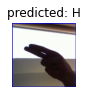

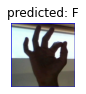

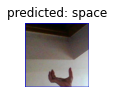

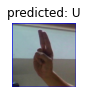

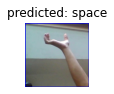

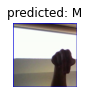

In [10]:
visualize_model(model)